In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from bikesharing.ml_logic.encoders import encode_district_label

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


from colorama import Fore, Style
from pathlib import Path
import requests

from bikesharing.params import *

from bikesharing.ml_logic.feature_engineering import feature_selection
from bikesharing.ml_logic.data import get_raw_data, get_polygons
from bikesharing.params import *

from pathlib import Path
from colorama import Fore, Style

import holidays
from datetime import date

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
def preprocess_features(df: pd.DataFrame):
    def create_preprocessor() -> ColumnTransformer:

        # SCALE PIPE
        scaler_pipe = Pipeline([
            ('scaler', MinMaxScaler())
        ])

        return scaler_pipe

    X = df[['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'windspeed_10m_max', 'precipitation_sum', 'month_sin',
       'month_cos', 'day_sin', 'day_cos']]
    

    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X)

    return pd.concat([pd.DataFrame(X_processed) , df[['is_holiday', 'is_weekend']]] , axis=1)

In [3]:
def get_weather_data_daily(
        cache_path:Path,
        data_has_header=True):
    """
    Retrieve the historical weather data from 'start_year' to 'end_year' from the
    Open Meteo Api.
    """

    if cache_path.is_file():
        print(Fore.BLUE + "\nLoad weather_data from local CSV..." + Style.RESET_ALL)
        historical_weather_data_df = pd.read_csv(cache_path, header='infer' if data_has_header else None)
    else:
        base_url = 'https://archive-api.open-meteo.com/v1/archive'

        params = {
            'latitude': 48.70,
            'longitude': 13.46,
            'start_date' : f'{START_YEAR}-01-01',
            'end_date' : f'{END_YEAR}-12-31',
            'daily': ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min', 'precipitation_sum', 'windspeed_10m_max'],
            'timezone': 'Europe/Berlin'
            
        }

        historical_weather_data = requests.get(base_url , params=params).json()

        if 'daily' not in historical_weather_data.keys():
            print('''Error while requesting from the API. Please check if the API is stil working with the following URL:\nhttps://archive-api.open-meteo.com/v1/archive?latitude=52.52&longitude=13.41&start_date=2023-05-25&end_date=2023-06-08&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,windspeed_10m_max&timezone=Europe%2FBerlin\nIf the API is working check your code!''')
            
            
                  
            

        historical_weather_data_df = pd.DataFrame(historical_weather_data['daily'])

        if historical_weather_data_df.shape[0] > 1:
            historical_weather_data_df.to_csv(cache_path, header=data_has_header, index=False)
            print(f'columns: {historical_weather_data_df.columns}')

    print(f"✅ Data loaded, with shape {historical_weather_data_df.shape}")

    return historical_weather_data_df

In [4]:
# GROUP BY DAY
def group_rental_data_by_day(df: pd.DataFrame) -> pd.DataFrame:
    """
    Groups the rental data by day.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with rental data grouped by day.
    """
    # Preprocessing
    df['STARTTIME'] = pd.to_datetime(df['STARTTIME'])
    df['rent_date_day'] = df['STARTTIME'].dt.floor('D')

    # Grouping by Hour
    df_by_day = df.groupby(by='rent_date_day')[df.columns[1:-1]].sum()

    return df_by_day.reset_index()

In [5]:
def encode_temporal_features_daily(datetime_column: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes temporal features (hour, month, day) in the DataFrame using sine and cosine transformations.

    Args:
        datetime_column (pd.Series): The input series with datetime values.

    Returns:
        pd.DataFrame: The DataFrame with encoded temporal features.
    """
    # Create a new DataFrame to hold the encoded features
    encoded_df = pd.DataFrame()
    encoded_df['rent_date_day'] = datetime_column['rent_date_day']

    # Extract hour, month, and day from the datetime_column
    encoded_df['hour'] = datetime_column['rent_date_day'].dt.hour.apply(lambda x: x+1)
    encoded_df['month'] = datetime_column['rent_date_day'].dt.month
    encoded_df['day'] = datetime_column['rent_date_day'].dt.day

    temporal_features = ['hour', 'month', 'day']

    # Apply sine and cosine transformations to the temporal features
    for feature in temporal_features:
        encoded_df[f'{feature}_sin'] = np.sin(2 * np.pi * encoded_df[feature] / encoded_df[feature].max())
        encoded_df[f'{feature}_cos'] = np.cos(2 * np.pi * encoded_df[feature] / encoded_df[feature].max())

    encoded_df.drop(columns=temporal_features, inplace=True)

    return encoded_df

In [6]:
# Function for Holiday Flag
def is_holiday(data: pd.DataFrame):
    """
    Performs feature engineering on the input data.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        DataFrame: A DataFrame containing the Holiday Flags.
    """
    df = data.copy()
    df['rent_date_day'] = pd.to_datetime(df['rent_date_day'])

    # Extract date from rent_date_day
    date_column = df['rent_date_day'].dt.date

    # Checking for the Bayern Holidays
    bay_holidays = holidays.CountryHoliday('DE', prov='BY')

    df['is_holiday'] = date_column.apply(lambda x: 1 if x in bay_holidays else 0)

    return df[['rent_date_day', 'is_holiday']]


# Function for Weekend Flag
def is_weekend(data: pd.DataFrame):
    """
    Performs feature engineering on the input data.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        DataFrame: A DataFrame containing the Weekend Flags.
    """
    df = data.copy()
    df['rent_date_day'] = pd.to_datetime(df['rent_date_day'])

    # Extract date from rent_date_day
    date_column = data['rent_date_day'].dt.date

    # Checking if Day is a Weekend or not
    df["is_weekend"] = date_column.apply(lambda x: 1 if x.weekday() >= 5 else 0)

    return df[['rent_date_day', 'is_weekend']]

In [7]:
def preprocess():
    """
    1. call get_raw_data
    2. drop cols
    3. clean (rm duplicates)
    3. encode y
    4. aggregate by hour
    5. join with weather data (get_weather_data)
    6. feature engineering & merge
    7. feature selection
    8. preproc-pipeline
    """

    cache_path_X_preproc=Path(f'{LOCAL_DATA_PATH}/processed/X_processed_from_{START_YEAR}_to_{END_YEAR}.csv')
    cache_path_y_preproc=Path(f'{LOCAL_DATA_PATH}/processed/y_processed_from_{START_YEAR}_to_{END_YEAR}.csv')

    if cache_path_X_preproc.is_file():
        print(Fore.BLUE + "\nLoad preprocessed data from local CSV..." + Style.RESET_ALL)
        X_processed = pd.read_csv(cache_path_X_preproc , header='infer')
        y = pd.read_csv(cache_path_y_preproc , header='infer')
        if X_processed.shape[0] == y.shape[0]:
            return X_processed , y
        print('\nShape mismatch between y and X')
        return None

    print(Fore.BLUE + "\nPreprocessing Data..." + Style.RESET_ALL)

    # 1. get_raw_data
    query =f'''
        SELECT *
        FROM `{GCP_PROJECT}.{BQ_DATASET}.raw_data_mvg`
    '''

    rental_data_df = get_raw_data(gcp_project=GCP_PROJECT , query=query , cache_path=Path(f'{LOCAL_DATA_PATH}/raw/mvg_rentals_from_{START_YEAR}_to_{END_YEAR}.csv'))

    # 2. drop cols
    rental_relavent_cols_df = rental_data_df[['STARTTIME' , 'STARTLAT' , 'STARTLON']]

    # 3. clean(rm duplicates)
    rental_relavent_cols_df = rental_relavent_cols_df.drop_duplicates()

    # 4. encode y
    encoded_rental_df = encode_district_label(rental_relavent_cols_df , get_polygons())

    # 5. aggregate by hour
    aggregated_rental_df = group_rental_data_by_day(encoded_rental_df)

    # 6. join with weather data
    weather_data_df = get_weather_data_daily(cache_path=Path(f'{LOCAL_DATA_PATH}/raw/histotical_weather_data_{START_YEAR}_to_{END_YEAR}.csv'))
    weather_data_df['time'] = pd.to_datetime(weather_data_df['time'])
    merged_df = aggregated_rental_df.merge(weather_data_df, right_on='time' , left_on='rent_date_day' , how='outer')
    merged_df['rent_date_day'] = merged_df['time']
    merged_df = merged_df.sort_values(by='rent_date_day').drop(columns=['time'])
    merged_df.fillna(0 , inplace=True)


    # Dropping leapyear data

    # merged_df['filter_time'] = merged_df['rent_date_day'].apply(lambda x: str(x)[5:10])
    # merged_df = merged_df[merged_df['filter_time'] != '02-29'].drop(columns=['filter_time'])

    # 7. feature enginering & merge
    holidays = is_holiday(merged_df[['rent_date_day']])
    merged_df = merged_df.merge(holidays , on='rent_date_day' , how='inner')

    weekends = is_weekend(merged_df[['rent_date_day']])
    merged_df = merged_df.merge(weekends , on='rent_date_day' , how='inner')

    encoded_date = encode_temporal_features_daily(merged_df[['rent_date_day']])
    merged_df = merged_df.merge(encoded_date , on='rent_date_day' , how='inner')

    # 8. feature selection


    # Dropping leapyear data

    districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

    X = merged_df.drop(columns=districts)
    y = merged_df[districts]

    print(f'X_shape: {X.shape}')
    print(f'y_shape: {y.shape}')

    features = ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'windspeed_10m_max', 'precipitation_sum', 'month_sin',
       'month_cos', 'day_sin', 'day_cos','is_holiday', 'is_weekend']
    

    selected_merged_df = feature_selection(X , features)

    # 9. preproc-pipeline (Keep date_time for RNN)
    X_processed = preprocess_features(selected_merged_df)

    X_processed.columns = features
    X_processed.to_csv(cache_path_X_preproc , header=True , index=False)
    y.to_csv(cache_path_y_preproc , header=True , index=False)

    if X_processed.shape[0] == y.shape[0]:
            return X_processed , y

    print('\nShape mismatch between y and X')
    return None

In [8]:
preprocess()


Load preprocessed data from local CSV...


(      temperature_2m_max  temperature_2m_min  apparent_temperature_max  \
 0               0.224658            0.440828                  0.237069   
 1               0.156164            0.292899                  0.140086   
 2               0.071233            0.260355                  0.066810   
 3               0.076712            0.144970                  0.088362   
 4               0.142466            0.346154                  0.155172   
 ...                  ...                 ...                       ...   
 1456            0.309589            0.399408                  0.303879   
 1457            0.243836            0.337278                  0.269397   
 1458            0.312329            0.369822                  0.327586   
 1459            0.290411            0.434911                  0.306034   
 1460            0.421918            0.467456                  0.441810   
 
       apparent_temperature_min  windspeed_10m_max  precipitation_sum  \
 0                     0.

In [9]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [10]:
df_X

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,windspeed_10m_max,precipitation_sum,month_sin,month_cos,day_sin,day_cos,is_holiday,is_weekend
0,0.224658,0.440828,0.237069,0.334928,0.698592,0.139286,0.75,0.933013,0.600779,0.989739,1,0
1,0.156164,0.292899,0.140086,0.224880,0.661972,0.121429,0.75,0.933013,0.697431,0.959375,0,0
2,0.071233,0.260355,0.066810,0.191388,0.616901,0.050000,0.75,0.933013,0.786001,0.910151,0,0
3,0.076712,0.144970,0.088362,0.136364,0.526761,0.150000,0.75,0.933013,0.862862,0.844083,0,0
4,0.142466,0.346154,0.155172,0.270335,0.639437,0.567857,0.75,0.933013,0.924867,0.763876,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.309589,0.399408,0.303879,0.344498,0.464789,0.103571,0.50,1.000000,0.137138,0.844083,0,0
1457,0.243836,0.337278,0.269397,0.315789,0.070423,0.000000,0.50,1.000000,0.213999,0.910151,0,0
1458,0.312329,0.369822,0.327586,0.332536,0.109859,0.003571,0.50,1.000000,0.302569,0.959375,0,0
1459,0.290411,0.434911,0.306034,0.401914,0.219718,0.014286,0.50,1.000000,0.399221,0.989739,0,0


In [11]:
df_y

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,14.0,11.0,4.0,4.0,8.0,0.0,1.0,1.0,0.0,10.0,...,11.0,16.0,5.0,0.0,1.0,0.0,0.0,9.0,9.0,0.0
1,27.0,7.0,2.0,13.0,8.0,0.0,0.0,2.0,0.0,7.0,...,5.0,12.0,2.0,1.0,2.0,0.0,0.0,8.0,8.0,0.0
2,24.0,11.0,2.0,7.0,11.0,0.0,0.0,2.0,0.0,5.0,...,15.0,15.0,4.0,0.0,2.0,0.0,0.0,6.0,6.0,0.0
3,10.0,7.0,0.0,7.0,7.0,0.0,0.0,2.0,0.0,13.0,...,5.0,14.0,5.0,0.0,3.0,0.0,0.0,10.0,10.0,0.0
4,9.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,59.0,33.0,0.0,4.0,16.0,0.0,3.0,0.0,0.0,17.0,...,17.0,18.0,13.0,0.0,3.0,1.0,1.0,20.0,20.0,0.0
1457,72.0,34.0,0.0,14.0,31.0,0.0,3.0,2.0,2.0,15.0,...,21.0,25.0,7.0,4.0,6.0,0.0,0.0,18.0,18.0,0.0
1458,97.0,64.0,0.0,10.0,37.0,0.0,2.0,2.0,0.0,16.0,...,30.0,33.0,19.0,1.0,3.0,0.0,0.0,22.0,22.0,0.0
1459,80.0,46.0,0.0,13.0,30.0,0.0,6.0,4.0,0.0,18.0,...,28.0,36.0,15.0,3.0,10.0,1.0,1.0,36.0,36.0,0.0


# XGBoost

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bikesharing.ml_logic.model import get_folds

In [13]:
df_X_y = pd.concat((df_X, df_y) , axis=1)

In [38]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

In [20]:
########## MODEL #########
FOLD_LENGTH = 365
FOLD_STRIDE = 365
TRAIN_TEST_RATIO = 0.8
INPUT_LENGTH = 336
OUTPUT_LENGTH = 24

In [21]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [29]:
district_score_means_r2 = []
district_score_means_rmse = []

for dist in districts:
    scores_list = []

    for i, fold in enumerate(fold_dfs):
        folds = fold_dfs[:]
        test_df = folds[i]
        del folds[i]
        train_dfs = folds    
        
        train_df = pd.concat(train_dfs, axis=0)
        
        X_test = test_df.drop(columns=districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns=districts)
        y_train = train_df[dist]
        
        xgb_r = XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=123)
        xgb_r.fit(X_train, y_train)
        y_pred = xgb_r.predict(X_test)
        print(f"{y_pred=}")
        scores_r2 = r2_score(y_test, y_pred)
        scores_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        # print(f"R2 Score = {scores_r2}")
        # print(f"RMSE Score = {scores_rmse}")
        
    scores_array_r2 = np.array(scores_r2)
    scores_array_rmse = np.array(scores_rmse)

    scores_array_r2 = scores_array_r2.flatten()
    scores_array_rmse = scores_array_rmse.flatten()
    
    district_score_means_r2.append(np.mean(scores_array_r2))
    district_score_means_rmse.append(np.mean(scores_array_rmse))


y_pred=array([ 48.32923 ,  47.27767 ,  48.586243,  28.876541,  39.508575,
        36.22377 ,  65.86479 ,  53.68489 ,  50.66269 ,  52.052406,
        28.876541,  37.91893 ,  50.149635,  60.392   ,  48.41637 ,
        68.53517 ,  66.18511 ,  54.341522,  17.129236,  17.129236,
        36.1678  ,  36.1678  ,  36.1678  ,  36.1678  ,  36.1678  ,
        28.320023,  58.978268,  48.645073,  30.86832 ,  53.243534,
        51.33604 ,  66.2345  ,  60.356323,  37.06531 ,  33.241608,
        29.851011,  29.851011,  47.94228 ,  60.878555, 100.179794,
        90.953995,  70.443146,  59.109673,  79.98001 ,  73.5006  ,
        94.8226  ,  88.13848 , 101.08132 ,  94.8226  ,  93.9367  ,
        80.88242 ,  95.828415,  85.41756 ,  18.103962,  72.22085 ,
        94.13835 ,  90.51103 , 100.73233 , 108.007065,  75.47239 ,
        71.846245,  91.01389 , 118.51384 ,  74.85666 ,  95.9809  ,
        96.54256 , 124.37283 , 103.600426,  84.5301  ,  72.17294 ,
        74.78373 ,  78.31332 ,  76.953804,  76.95977 , 

In [30]:
print(f"mean = {np.mean(district_score_means_r2)}")
print(f"min = {np.min(district_score_means_r2)}")
print(f"max = {np.max(district_score_means_r2)}")

mean = -2.8431950413012888
min = -75.72006863926302
max = 0.6545130502806196


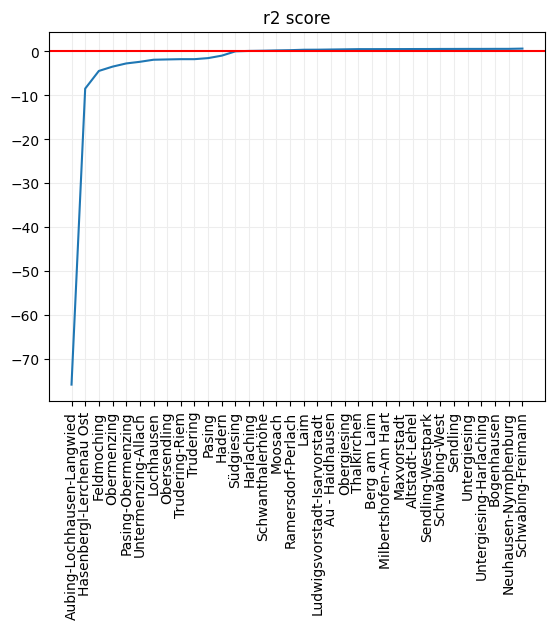

In [34]:
scores_df = pd.DataFrame(district_score_means_r2, columns=['score'], index=districts)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('r2 score')
plt.grid(c='#ededed')


plt.show()

In [31]:
print(f"mean = {np.mean(district_score_means_rmse)}")
print(f"min = {np.min(district_score_means_rmse)}")
print(f"max = {np.max(district_score_means_rmse)}")

mean = 20.150758504990645
min = 0.8366535020576564
max = 83.9218874884506


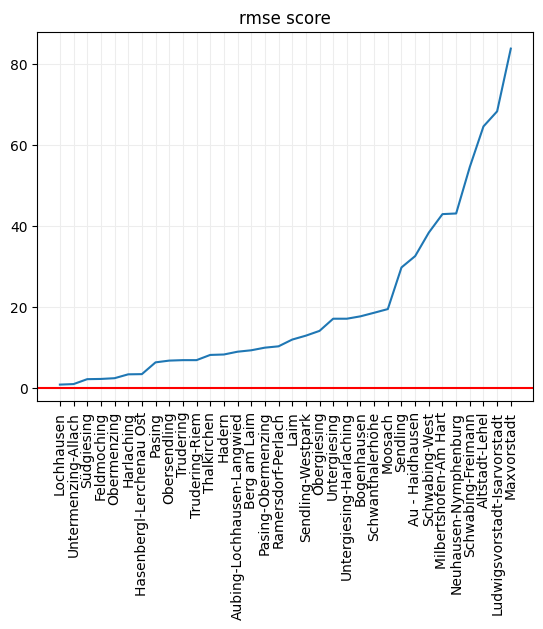

In [35]:
scores_df = pd.DataFrame(district_score_means_rmse, columns=['score'], index=districts)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('rmse score')
plt.grid(c='#ededed')


plt.show()

# Dropped Dist

In [39]:
districts_dropped = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Berg am Laim', 'Bogenhausen',
       'Harlaching',
       'Laim', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing',
       'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Thalkirchen',
       'Untergiesing', 'Untergiesing-Harlaching']

In [40]:
district_score_means_r2 = []
district_score_means_rmse = []

for dist in districts_dropped:
    scores_list = []

    for i, fold in enumerate(fold_dfs):
        folds = fold_dfs[:]
        test_df = folds[i]
        del folds[i]
        train_dfs = folds    
        
        train_df = pd.concat(train_dfs, axis=0)
        
        X_test = test_df.drop(columns=districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns=districts)
        y_train = train_df[dist]
        
        xgb_r = XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=123)
        xgb_r.fit(X_train, y_train)
        y_pred = xgb_r.predict(X_test)
        print(f"{y_pred=}")
        scores_r2 = r2_score(y_test, y_pred)
        scores_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        # print(f"R2 Score = {scores_r2}")
        # print(f"RMSE Score = {scores_rmse}")
        
    scores_array_r2 = np.array(scores_r2)
    scores_array_rmse = np.array(scores_rmse)

    scores_array_r2 = scores_array_r2.flatten()
    scores_array_rmse = scores_array_rmse.flatten()
    
    district_score_means_r2.append(np.mean(scores_array_r2))
    district_score_means_rmse.append(np.mean(scores_array_rmse))


y_pred=array([ 48.32923 ,  47.27767 ,  48.586243,  28.876541,  39.508575,
        36.22377 ,  65.86479 ,  53.68489 ,  50.66269 ,  52.052406,
        28.876541,  37.91893 ,  50.149635,  60.392   ,  48.41637 ,
        68.53517 ,  66.18511 ,  54.341522,  17.129236,  17.129236,
        36.1678  ,  36.1678  ,  36.1678  ,  36.1678  ,  36.1678  ,
        28.320023,  58.978268,  48.645073,  30.86832 ,  53.243534,
        51.33604 ,  66.2345  ,  60.356323,  37.06531 ,  33.241608,
        29.851011,  29.851011,  47.94228 ,  60.878555, 100.179794,
        90.953995,  70.443146,  59.109673,  79.98001 ,  73.5006  ,
        94.8226  ,  88.13848 , 101.08132 ,  94.8226  ,  93.9367  ,
        80.88242 ,  95.828415,  85.41756 ,  18.103962,  72.22085 ,
        94.13835 ,  90.51103 , 100.73233 , 108.007065,  75.47239 ,
        71.846245,  91.01389 , 118.51384 ,  74.85666 ,  95.9809  ,
        96.54256 , 124.37283 , 103.600426,  84.5301  ,  72.17294 ,
        74.78373 ,  78.31332 ,  76.953804,  76.95977 , 

In [41]:
print(f"mean = {np.mean(district_score_means_r2)}")
print(f"min = {np.min(district_score_means_r2)}")
print(f"max = {np.max(district_score_means_r2)}")

mean = 0.47720343366860923
min = 0.1272377645966728
max = 0.6545130502806196


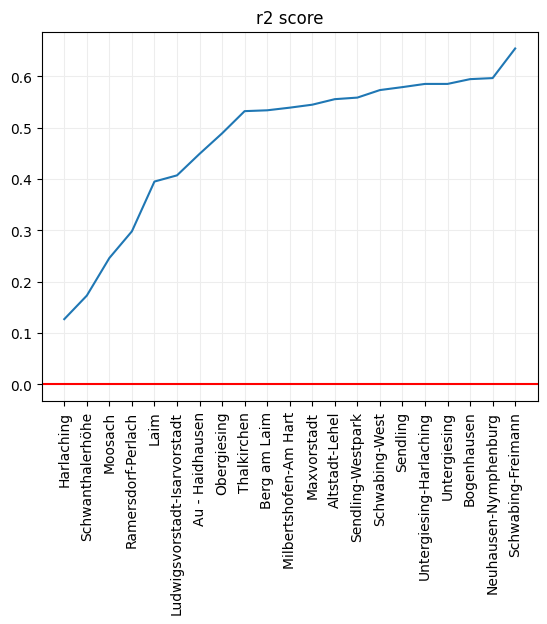

In [44]:
scores_df = pd.DataFrame(district_score_means_r2, columns=['score'], index=districts_dropped)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('r2 score')
plt.grid(c='#ededed')


plt.show()

In [42]:
print(f"mean = {np.mean(district_score_means_rmse)}")
print(f"min = {np.min(district_score_means_rmse)}")
print(f"max = {np.max(district_score_means_rmse)}")

mean = 29.474455917192273
min = 3.3768097583974606
max = 83.9218874884506


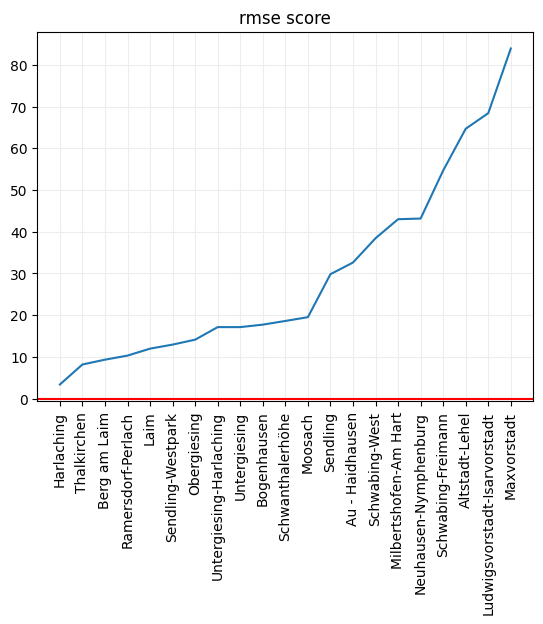

In [45]:
scores_df = pd.DataFrame(district_score_means_rmse, columns=['score'], index=districts_dropped)

scores_df.sort_values(by=['score'], inplace=True) 

plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('rmse score')
plt.grid(c='#ededed')


plt.show()